In [1]:
from backend.image import Image, Marker, MarkerRectangle2D, MarkerFill2D, MarkerContainer
from backend.filters import  filters_2dim as filters_2d
from backend.filters import  filters_3dim as filters_3d
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from backend import MarkerMakerRectangle2DBinary, Accuracy, Segmentation, Evaluator, MarkerBorder2D
import os
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from directory import Directory

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
PATH_TO_IMG_FOLDER = 'C:/Users/maxxx/VSprojects/back/0/0'
PATH_TO_BORDER_IMG = r'C:\Users\maxxx\VSprojects\back\0\0\border\border00001.png'

FOLDER = Directory(main_path=PATH_TO_IMG_FOLDER)   # Хранилище названий изображений по папкам

# 2D Сегментация

### Загрузка снимка низкого качества, отображение разметки для обучения, выделение границы, которую не нужно учитывать при расчете метрик

instances of class 1 = (606176,)
instances of class 0 = (393824,)


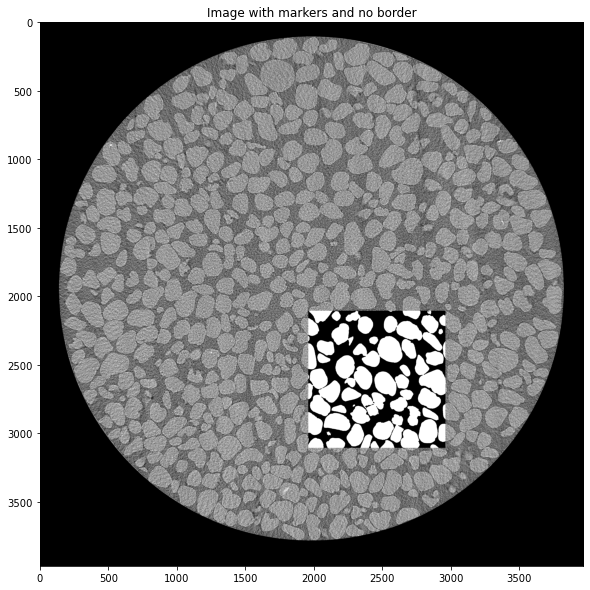

In [3]:
%matplotlib inline 

image = Image(path_to_image=FOLDER.ang_dec_folder[0])
orig_image = Image(path_to_image=FOLDER.orign_folder[0])

point1 = (1957, 2106)
point2 = (1957 + 1000, 2106 + 1000)

markers = MarkerMakerRectangle2DBinary(FOLDER.segmented_folder[0], *point1, *point2).get_markers()
for marker in markers:
    image.draw_marker(marker, color=marker.value * 255)

border_marker = MarkerBorder2D(Image(path_to_image=PATH_TO_BORDER_IMG))
image.draw_marker(border_marker, color=0)
image.show(title="Image with markers and no border") 
image.reset()

### Применение 2д фильтров, сегментация, расчет accuracy

Appplying filters...


  0%|          | 0/6 [00:00<?, ?it/s]

Making train data...
Fitting model...
x_train shape = (1000000, 6), y_train shape = (1000000,)
Making predictions...


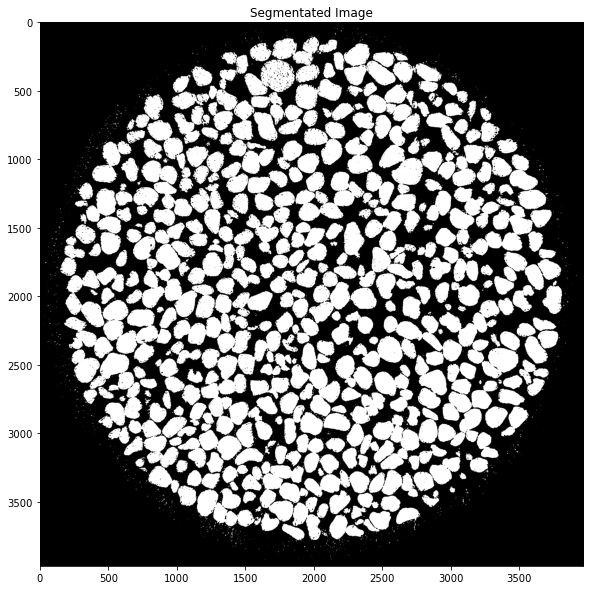

{'Accuracy': 0.9636066016472958}

In [9]:
%matplotlib inline 

filters = [
            filters_2d.MedianFilter(size=5),   filters_2d.GaussianFilter(15),  filters_2d.LaplacianDifference(),
            filters_2d.VarianceFilter(size=3), filters_2d.HighPassFilter(k=9), filters_2d.BaseFilter2D(), 
#             filters_2d.Erosion(size=3), filters_2d.Dilation(size=3),
#             filters_2d.Closing(size=3), filters_2d.Opening(size=3)
          ]

scalled_filters =[
            filters_2d.MedianFilter(size=5, scale=4),   filters_2d.GaussianFilter(15, scale=4),  filters_2d.LaplacianDifference(scale=4),
            filters_2d.VarianceFilter(size=3, scale=4), filters_2d.HighPassFilter(k=9, scale=4), filters_2d.BaseFilter2D(scale=4), 
            filters_2d.Erosion(size=3, scale=4), filters_2d.Dilation(size=3, scale=4),
            filters_2d.Closing(size=3, scale=4), filters_2d.Opening(size=3, scale=4)
          ]

filters #+= scalled_filters

sgm = Segmentation(model=LogisticRegression(n_jobs=-1), filters=filters)

result = sgm.fit_and_predict(image, markers)
result.show(title='Segmentated Image')


ground_truth = Image(path_to_image=FOLDER.segmented_folder[0], dim=2)
Evaluator.evaluate(result, ground_truth, markers, border_marker, Accuracy)

In [6]:
pprint(sgm.feature_weights())

{'Base Filter scale=1': 0.012595587791643492,
 'Base Filter scale=4': 0.052593333474763096,
 'Closing 2D scale=1': 0.028000727373070314,
 'Closing 2D scale=4': 0.1635787067214817,
 'Dilation 2D scale=1': 0.014037992880136449,
 'Dilation 2D scale=4': 0.05897809307513431,
 'Erosion 2D scale=1': 0.010253352035147378,
 'Erosion 2D scale=4': 0.07969133223573598,
 'Gaussian Filter sigma=15 scale=1': 0.0846729368853757,
 'Gaussian Filter sigma=15 scale=4': 0.0070496425762436084,
 'High Pass Filter k=9 scale=1': 0.0010964253174696923,
 'High Pass Filter k=9 scale=4': 0.004499821681777208,
 'Laplacian Difference scale=1': 0.0028614461132403703,
 'Laplacian Difference scale=4': 0.003939072213325721,
 'Median Filter size=5 scale=1': 0.0838357029595103,
 'Median Filter size=5 scale=4': 0.1924227117288731,
 'Opening 2D scale=1': 0.02139426397809629,
 'Opening 2D scale=4': 0.17323651304327675,
 'Variance Filter scale=1': 0.0012464399826768876,
 'Variance Filter scale=4': 0.0040158979330216435}


In [10]:
%matplotlib qt
arr = np.zeros_like(ground_truth.data)
arr[ground_truth.data != 255 * result.data] = 255
# Image(
#     data=arr
# ).show()


Image.show_images(2, 2, result, ground_truth, orig_image, arr, p1=(1000, 1000), p2=(1500, 1500))

In [16]:
# new_result = np.copy(result.data)
# new_result = filters_2d.Closing(size=6).make_mask(new_result)
# Image(
#     data=new_result
# ).show()

# Image.show_images(2, 2, new_result, ground_truth, orig_image, ground_truth.data-new_result, p1=(1000, 1000), p2=(1500, 1500))
# Evaluator.evaluate(new_result, ground_truth, markers, border_marker, Accuracy)

Appplying filters...


  0%|          | 0/28 [00:00<?, ?it/s]

Making train data...
Fitting model...
x_train shape = (1000000, 28), y_train shape = (1000000,)
Making predictions...


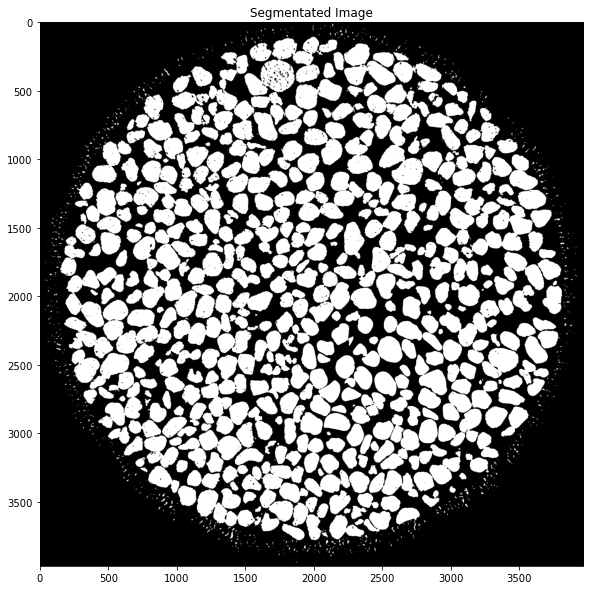

{'Median Filter size=5 scale=1': 0.04888481661471488, 'Gaussian Filter sigma=15 scale=1': 0.1719002154451788, 'Laplacian Difference scale=1': 0.001978142708207217, 'Variance Filter scale=1': 0.0008201495235713676, 'High Pass Filter k=9 scale=1': 0.0006655209215154374, 'Base Filter scale=1': 0.01441675329652338, 'Erosion 2D scale=1': 0.024418180784141482, 'Dilation 2D scale=1': 0.019578857651683414, 'Closing 2D scale=1': 0.053497147699116746, 'Opening 2D scale=1': 0.013963706433640134, 'Median Filter size=5 scale=2': 0.2183894154408874, 'Gaussian Filter sigma=15 scale=2': 0.014620240354839222, 'Laplacian Difference scale=2': 0.0026072414764361884, 'Variance Filter scale=2': 0.0024981441954259223, 'High Pass Filter k=9 scale=2': 0.0031308868612125026, 'Base Filter scale=2': 0.04971108782834005, 'Median Filter size=5 scale=4': 0.15379523478631837, 'Gaussian Filter sigma=15 scale=4': 0.00380314133220107, 'Laplacian Difference scale=4': 0.0026533134296567945, 'Variance Filter scale=4': 0.00

In [8]:
%matplotlib inline 



filters_ = [
            filters_2d.MedianFilter(size=5),   filters_2d.GaussianFilter(15),  filters_2d.LaplacianDifference(),
            filters_2d.VarianceFilter(size=3), filters_2d.HighPassFilter(k=9), filters_2d.BaseFilter2D(), 
            filters_2d.Erosion(size=3), filters_2d.Dilation(size=3),
            filters_2d.Closing(size=3), filters_2d.Opening(size=3)
          ]

for scale in [2, 4, 8]:
    filters_ += [
            filters_2d.MedianFilter(size=5, scale=scale),   filters_2d.GaussianFilter(15, scale=scale),  filters_2d.LaplacianDifference(scale=scale),
            filters_2d.VarianceFilter(size=3, scale=scale), filters_2d.HighPassFilter(k=9, scale=scale), filters_2d.BaseFilter2D(scale=scale), 
                ]


sgm = Segmentation(model=RandomForestClassifier(n_jobs=-1), filters=filters_)

result = sgm.fit_and_predict(image, markers)
result.show(title='Segmentated Image')

ground_truth = Image(path_to_image=FOLDER.segmented_folder[0], dim=2)
print(sgm.feature_weights())
Evaluator.evaluate(result, ground_truth, markers, border_marker, Accuracy)

### lightgbm

In [17]:
%matplotlib inline 
from lightgbm import LGBMClassifier

sgm = Segmentation(model=LGBMClassifier(), filters=filters)

result = sgm.fit_and_predict(image, markers)
# result.show(title='Segmentated Image')

Evaluator.evaluate(result, ground_truth, markers, border_marker, Accuracy) #9617

Appplying filters...


  0%|          | 0/20 [00:00<?, ?it/s]

Making train data...
Fitting model...
[LightGBM] [Info] Number of positive: 606176, number of negative: 393824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3989
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.606176 -> initscore=0.431266
[LightGBM] [Info] Start training from score 0.431266
x_train shape = (1000000, 20), y_train shape = (1000000,)
Making predictions...


{'Accuracy': 0.9731129322074388}

In [19]:
sgm.feature_weights()

{'Median Filter size=5 scale=1': 187,
 'Gaussian Filter sigma=15 scale=1': 306,
 'Laplacian Difference scale=1': 7,
 'Variance Filter scale=1': 5,
 'High Pass Filter k=9 scale=1': 4,
 'Base Filter': 65,
 'Erosion 2D scale=1': 195,
 'Dilation 2D scale=1': 176,
 'Closing 2D scale=1': 0,
 'Opening 2D scale=1': 0,
 'Median Filter size=5 scale=4': 176,
 'Gaussian Filter sigma=15 scale=4': 525,
 'Laplacian Difference scale=4': 125,
 'Variance Filter scale=4': 85,
 'High Pass Filter k=9 scale=4': 181,
 'Erosion 2D scale=4': 376,
 'Dilation 2D scale=4': 389,
 'Closing 2D scale=4': 49,
 'Opening 2D scale=4': 97}

### Применение обученной модели на 100 2д срезов исходного 3д снимка

In [26]:
from tqdm.notebook import tqdm
from backend import Image3D
sgm.informing = False

In [32]:
img_3d           = Image3D(img_pathes = FOLDER.ang_dec_folder)
img_3d_segmented = Image3D(img_pathes = FOLDER.segmented_folder)

print(f'3D Image shape = {img_3d.shape}')

sum_acc = 0
n = 0

for img_indx in tqdm(range(len(img_3d))):
    if img_indx != 0:
        img_2d_slice = img_3d[img_indx]
        ground_truth = img_3d_segmented[img_indx]
        
        result = sgm.predict(image = img_2d_slice)
        acc = Evaluator.evaluate(result, ground_truth, [], border_marker, Accuracy)[Accuracy.name]
        
        print(f'Accuracy at step {img_indx} = {acc}')
        sum_acc += acc
        n += 1
    
print(f'Mean accuracy = {sum_acc / n} per {n} images')

3D Image shape = (100, 3968, 3968)


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy at step 1 = 0.964536267748097
Accuracy at step 2 = 0.9646857798812559
Accuracy at step 3 = 0.9647480687624084
Accuracy at step 4 = 0.9650010820576032
Accuracy at step 5 = 0.9650882112176441
Accuracy at step 6 = 0.9650581017886882
Accuracy at step 7 = 0.9650956444829176
Accuracy at step 8 = 0.9652480734670067
Accuracy at step 9 = 0.9655040036131315
Accuracy at step 10 = 0.9656265113521957
Accuracy at step 11 = 0.9655256447651935
Accuracy at step 12 = 0.9653238174992237
Accuracy at step 13 = 0.9652259618551172
Accuracy at step 14 = 0.9653637124925902
Accuracy at step 15 = 0.965482080185173
Accuracy at step 16 = 0.9656856011065215
Accuracy at step 17 = 0.9659751220843252
Accuracy at step 18 = 0.9660516188522662
Accuracy at step 19 = 0.9659996800873173
Accuracy at step 20 = 0.965991117718458
Accuracy at step 21 = 0.965973522520912
Accuracy at step 22 = 0.9657167455470977
Accuracy at step 23 = 0.9657551350690164
Accuracy at step 24 = 0.9656941634753808
Accuracy at step 25 = 0.96571

In [33]:
print(f'Mean accuracy = {round(sum_acc / n, 3)} per {n} images')

Mean accuracy = 0.966 per 99 images


# 3D Сегментация

In [4]:
from backend import MarkerMaker3DBinary, Segmentation3D, Image3D
import backend.filters.filters_3dim as filters_3d

img_3d           = Image3D(img_pathes = FOLDER.ang_dec_folder)
img_3d_segmented = Image3D(img_pathes = FOLDER.segmented_folder)

In [5]:


point1 = (1957,       2106,       0)
point2 = (1957 + 100, 2106 + 500, 0 + 4)


markers_3d = MarkerMaker3DBinary(*point1, *point2).get_markers(img_3d_segmented)
filters_3d = [
            filters_3d.GaussianFilter(sigma=3),  filters_3d.LaplacianDifference(),
            filters_3d.VarianceFilter(size=3), filters_3d.BaseFilter3D(),  #filters_3d.MedianFilter(size=5)
          ]

sgm_3d = Segmentation3D(LogisticRegression(n_jobs=-1),
                            filters_3d,
                            batch_size=10, informing=True)

# sgm_3d.fit(img_3d, markers)

DEPTH_TO_PREDICT = 20

img_3d.clear_cache()
img_3d.load_images(0, DEPTH_TO_PREDICT - 1)
# preds = sgm_3d.predict(img_3d)
preds = sgm_3d.fit_and_predict(img_3d, markers_3d)
img_3d.clear_cache()


print(f'\npredictions shape = {preds.shape}')

instances of class 1 = (133097,)
instances of class 0 = (66903,)
Appplying filters...


  0%|          | 0/4 [00:00<?, ?it/s]

Making train data...
Fitting model...
Making predictions...

predictions shape = (20, 3968, 3968)


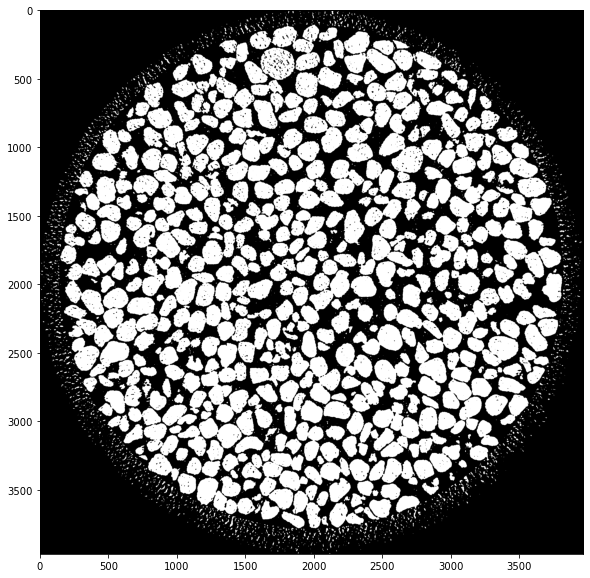

In [7]:
Image(
    data=preds[0]
).show()

### гифка с сегментированными снимками

In [35]:
import matplotlib.animation as animation
from matplotlib import pyplot as plt
from IPython.display import Image
import numpy as np


def make_animation(data: np.ndarray, h_step = 1, w_step = 1, file_name: str = None):
    if file_name is None or '.' not in file_name:
        file_name = 'test.gif'
            
    GIF_FPS = 8
    fig = plt.figure(figsize=(16, 12))
    all_frames = len(data)
    
    def animate(i: int):
        plt.title(f'depth = {i}')
        plt.imshow(data[i, ::w_step, ::h_step], cmap='gray')
        print(f'frame {i} / {all_frames}', end='\r')
    
    
    result = animation.FuncAnimation(fig, animate, frames=all_frames)
    result.save(file_name, writer='pillow', fps=GIF_FPS)
    plt.close()
    
    return file_name

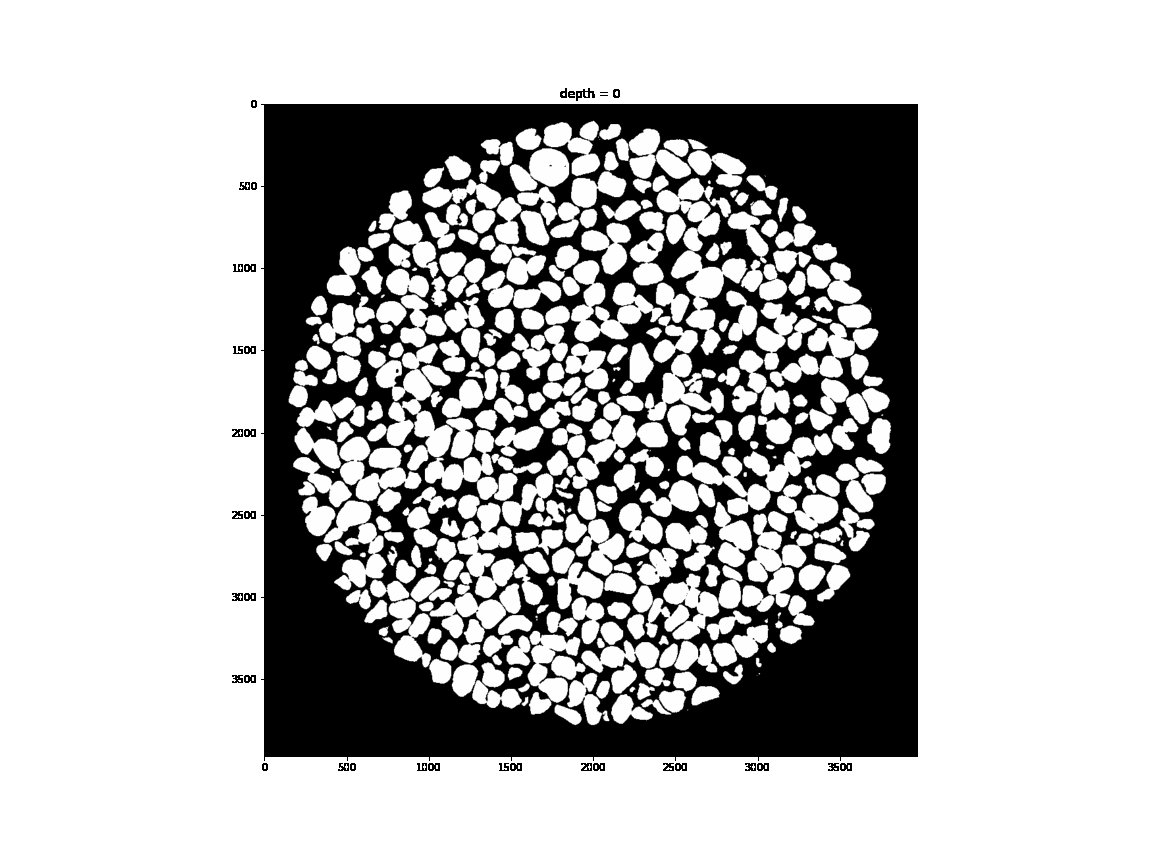

In [36]:
%matplotlib inline 
file_name = make_animation(preds)
Image(open(file_name,'rb').read())

In [6]:
#расчет accuracy для 3D изображания, глубиной в DEPTH_TO_PREDICT снимков


border_marker = MarkerBorder2D(Image(path_to_image=PATH_TO_BORDER_IMG))
EXTRA_VALUE = 999
mask = np.copy(preds)
for marker in markers_3d:
    x_indexes, y_indexes, z_indexes = marker.get_indexes()
    mask[z_indexes, y_indexes, x_indexes] = EXTRA_VALUE

x_indexes, y_indexes = border_marker.get_indexes()
mask[:, y_indexes, x_indexes] = EXTRA_VALUE

z_index_test, y_index_test, x_index_test  = np.where(mask != EXTRA_VALUE)


img_3d_segmented.load_images(0, DEPTH_TO_PREDICT - 1)

y_real = np.copy(img_3d_segmented.data[z_index_test, y_index_test, x_index_test])
y_pred = mask[z_index_test, y_index_test, x_index_test]

if np.max(y_pred) == 1:
    y_pred *= 255
Accuracy.get_score(y_pred=y_pred, y_real=y_real)

0.9667861582798859

In [7]:
from backend import Evaluator3D
print(preds.data.shape, img_3d_segmented.data.shape)
Evaluator3D.evaluate(preds, img_3d_segmented.data, markers_3d, border_marker, Accuracy)

(20, 3968, 3968) (20, 3968, 3968)


{'Accuracy': 0.9667861582798859}

## Сегментация всех изображений

In [1]:
from backend.image import Image, Marker, MarkerRectangle2D, MarkerFill2D, MarkerContainer
from backend.filters import  filters_2dim as filters_2d
from backend.filters import  filters_3dim as filters_3d
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from backend import MarkerMakerRectangle2DBinary, Accuracy, Segmentation, Evaluator, MarkerBorder2D, F1_binary, \
    EPorosity, IoU_pores, EvaluatorBorder
import os
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from directory import Directory

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
PATH_TO_FOLDER = r'C:\Users\maxxx\VSprojects\back\images'
PATH_TO_ANG_IMG = r'01. Reconstructed\02. Angular Decimation\02. x4'
PATH_TO_GT = r'02. Segmented\00. Original'
PATH_TO_BORDER_FOLDER = r'C:\Users\maxxx\VSprojects\back\0\0\border'

In [3]:
def get_pathes(number, image_name):
    path_to_img = os.path.join(PATH_TO_FOLDER, number, PATH_TO_ANG_IMG, image_name)
    path_to_border_img = os.path.join(PATH_TO_BORDER_FOLDER, f'{number}.png')
    path_to_gt = os.path.join(PATH_TO_FOLDER, number, PATH_TO_GT, image_name)
    return path_to_img, path_to_border_img, path_to_gt

In [26]:
def segmentate_img(number, image_name):
    SHOW = False
    number = str(number)
    path_to_img, path_to_border_img, path_to_gt = get_pathes(number, image_name)
    
    image = Image(path_to_img)
    
    border_marker = MarkerBorder2D(Image(path_to_image=path_to_border_img))
    point1 = (1957, 2106)
    point2 = (1957 + 1000, 2106 + 1000)
    markers = MarkerMakerRectangle2DBinary(path_to_gt, *point1, *point2).get_markers()
    if SHOW:
        image.draw_marker(border_marker, color=0)
        for marker in markers:
            image.draw_marker(marker, color=marker.value * 255)
        image.show(title="Image with markers and no border") 
        image.reset()
        
    filters = [
                filters_2d.MedianFilter(size=5),   filters_2d.GaussianFilter(15),
                filters_2d.VarianceFilter(size=6), filters_2d.HighPassFilter(k=9), filters_2d.BaseFilter2D(), 
                filters_2d.Erosion(size=3), filters_2d.Dilation(size=3),
                filters_2d.Closing(size=3), filters_2d.Opening(size=3)
              ]
    
    for ii in [2, 4]:
    
        scalled_filters =[
                    filters_2d.MedianFilter(size=5, scale=ii),   filters_2d.GaussianFilter(15, scale=ii),
                    filters_2d.BaseFilter2D(scale=ii), 
                    filters_2d.Erosion(size=3, scale=ii), filters_2d.Dilation(size=3, scale=ii),
                    filters_2d.Closing(size=3, scale=ii), filters_2d.Opening(size=3, scale=ii)
                  ]
        filters += scalled_filters

        
    sgm = Segmentation(model=RandomForestClassifier(n_jobs=-1), filters=filters)

    result = sgm.fit_and_predict(image, markers)
    result.show(title='Segmentated Image')
    return result, sgm

    


def score_result(number, image_name, result, N=3):
    number = str(number)
    path_to_img, path_to_border_img, path_to_gt = get_pathes(number, image_name)
    
    border_marker = MarkerBorder2D(Image(path_to_image=path_to_border_img))
    point1 = (1957, 2106)
    point2 = (1957 + 1000, 2106 + 1000)
    markers = MarkerMakerRectangle2DBinary(path_to_gt, *point1, *point2).get_markers()
    
    ground_truth = Image(path_to_image=path_to_gt, dim=2)
    
    METRICS = [Accuracy, F1_binary, EPorosity, IoU_pores]
    
#     print(111, np.unique(result.data), np.unique(ground_truth.data))
    
    res = Evaluator.evaluate(result, ground_truth, markers, border_marker, *METRICS)
#     print(res)
#     print(111, np.unique(result.data), np.unique(ground_truth.data))
    res_border = EvaluatorBorder.evaluate(N, result, ground_truth, markers, border_marker, *METRICS)
    for key, value in res_border.items():
        res[f'{key}_{N}'] = value
#     print(res, res_border)
    return res
    

instances of class 1 = (606176,)
instances of class 0 = (393824,)
Appplying filters...


  0%|          | 0/23 [00:00<?, ?it/s]

Making train data...
Fitting model...
x_train shape = (1000000, 23), y_train shape = (1000000,)
Making predictions...


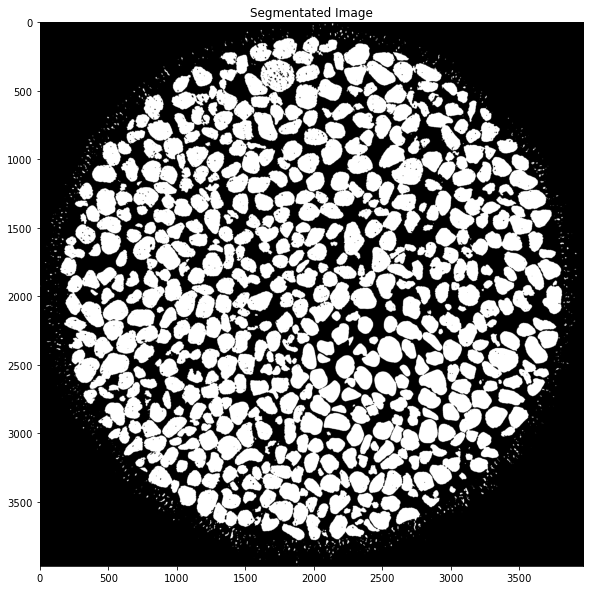

In [27]:
image_name = 'im_00001.png'
image_name_6 = 'im_02086.png'
res1, sgm1 = segmentate_img(0, image_name)

In [28]:
score_result(0, image_name, res1) # other size

instances of class 1 = (606176,)
instances of class 0 = (393824,)
[0 1] [0 1]


{'Accuracy': 0.9737720582889311,
 'F1 binary': 0.9781042239633019,
 'Porosity relative difference': 1.5480323772023328,
 'IoU_pores': 0.9366760863454112,
 'Accuracy_3': 0.7096745610815053,
 'F1 binary_3': 0.6977867460762648,
 'Porosity relative difference_3': 7.01329760412614,
 'IoU_pores_3': 0.5633091803207346}

In [29]:
sorted(sgm1.feature_weights().items(), key = lambda x: x[1])

[('High Pass Filter k=9 scale=1', 0.0007985731218451354),
 ('Variance Filter scale=1', 0.0008859245910268205),
 ('Base Filter scale=1', 0.003081780819140831),
 ('Gaussian Filter sigma=15 scale=4', 0.004047238701880789),
 ('Base Filter scale=4', 0.004426270423938631),
 ('Dilation 2D scale=1', 0.005646873278841033),
 ('Erosion 2D scale=1', 0.005757104226562102),
 ('Closing 2D scale=1', 0.005889263444950985),
 ('Gaussian Filter sigma=15 scale=2', 0.006786645499020177),
 ('Dilation 2D scale=2', 0.007853523380295137),
 ('Base Filter scale=2', 0.009407471369993913),
 ('Opening 2D scale=1', 0.01680112176672874),
 ('Median Filter size=5 scale=1', 0.019323353411345775),
 ('Dilation 2D scale=4', 0.026938893390497678),
 ('Erosion 2D scale=4', 0.04588456463758289),
 ('Erosion 2D scale=2', 0.05023483387891547),
 ('Gaussian Filter sigma=15 scale=1', 0.052841778876547486),
 ('Opening 2D scale=2', 0.07287519533444742),
 ('Closing 2D scale=2', 0.09245629325866003),
 ('Closing 2D scale=4', 0.11445007424

In [48]:
path_to_img, path_to_border_img, path_to_gt = get_pathes('0', image_name)
img_gt = Image(path_to_gt)
img_gt.show()

In [32]:
%matplotlib qt
img_gt.show()

NameError: name 'img_gt' is not defined

In [49]:
%matplotlib qt
mask = filters_2d.Dilation(size=3).make_mask(img_gt) - filters_2d.Erosion(size=3).make_mask(img_gt)
# img_orig = Image(path_to_img)
# img_orig.data[mask == 0] = 0
# img_orig.show()
Image(data=mask).show()

image number 0
instances of class 1 = (606176,)
instances of class 0 = (393824,)
Appplying filters...


  0%|          | 0/23 [00:00<?, ?it/s]

Making train data...
Fitting model...
x_train shape = (1000000, 23), y_train shape = (1000000,)
Making predictions...


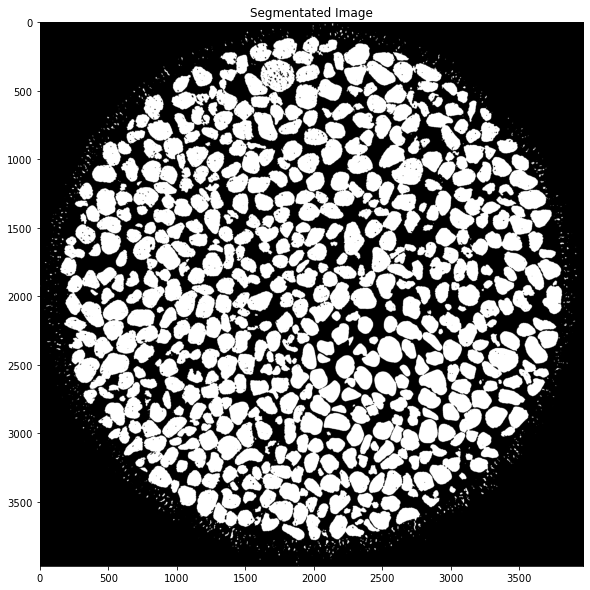

instances of class 1 = (606176,)
instances of class 0 = (393824,)
[0 1] [0 1]
[('High Pass Filter k=9 scale=1', 0.0007977111532008415), ('Variance Filter scale=1', 0.0008713679673713818), ('Base Filter scale=1', 0.0032672469273240844), ('Gaussian Filter sigma=15 scale=4', 0.004053966192153858), ('Dilation 2D scale=1', 0.004461198255746354), ('Base Filter scale=4', 0.004475407921751407), ('Erosion 2D scale=1', 0.004505735659477885), ('Closing 2D scale=1', 0.004747007919295009), ('Opening 2D scale=1', 0.005375709787648267), ('Gaussian Filter sigma=15 scale=2', 0.007465897971385847), ('Base Filter scale=2', 0.009291095758118076), ('Dilation 2D scale=4', 0.020348491309486016), ('Erosion 2D scale=2', 0.02431191859532387), ('Dilation 2D scale=2', 0.026246166870524116), ('Median Filter size=5 scale=1', 0.030747621853837406), ('Erosion 2D scale=4', 0.031755827901188576), ('Gaussian Filter sigma=15 scale=1', 0.035977967046286516), ('Opening 2D scale=2', 0.06235770953798154), ('Closing 2D scale=

  0%|          | 0/23 [00:00<?, ?it/s]

Making train data...
Fitting model...
x_train shape = (1000000, 23), y_train shape = (1000000,)
Making predictions...


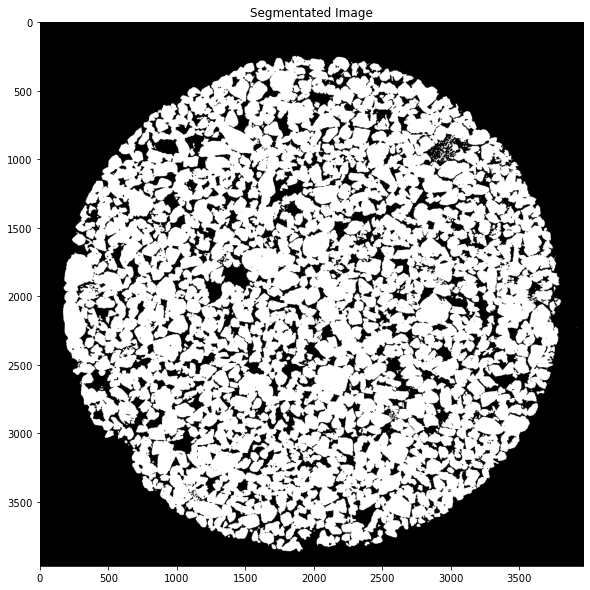

instances of class 1 = (757185,)
instances of class 0 = (242815,)
[0 1] [0 1]
[('High Pass Filter k=9 scale=1', 0.0009178512638610846), ('Variance Filter scale=1', 0.0012359440480706903), ('Gaussian Filter sigma=15 scale=4', 0.003456620496611688), ('Gaussian Filter sigma=15 scale=2', 0.004229449255509011), ('Dilation 2D scale=1', 0.005223316751167873), ('Base Filter scale=1', 0.006185666989581745), ('Gaussian Filter sigma=15 scale=1', 0.00626674216426628), ('Dilation 2D scale=4', 0.012794757282815532), ('Dilation 2D scale=2', 0.01363241861938444), ('Opening 2D scale=1', 0.01462790047780473), ('Base Filter scale=4', 0.01922961134243696), ('Erosion 2D scale=4', 0.020389426564279355), ('Base Filter scale=2', 0.026404930746472353), ('Erosion 2D scale=1', 0.029962629302443023), ('Closing 2D scale=4', 0.03579165475423961), ('Opening 2D scale=4', 0.045343318676367976), ('Closing 2D scale=1', 0.051991039239462564), ('Median Filter size=5 scale=4', 0.05356864319444924), ('Opening 2D scale=2', 0

  0%|          | 0/23 [00:00<?, ?it/s]

Making train data...
Fitting model...
x_train shape = (1000000, 23), y_train shape = (1000000,)
Making predictions...


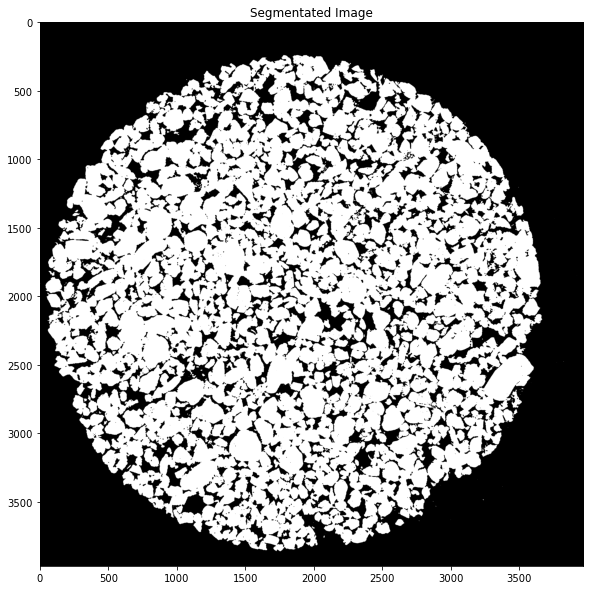

instances of class 1 = (738245,)
instances of class 0 = (261755,)
[0 1] [0 1]
[('High Pass Filter k=9 scale=1', 0.0012283703948811654), ('Variance Filter scale=1', 0.0016910142231078079), ('Gaussian Filter sigma=15 scale=4', 0.00481384936413713), ('Gaussian Filter sigma=15 scale=2', 0.005223624379741609), ('Base Filter scale=1', 0.005431651955648289), ('Dilation 2D scale=1', 0.006900660400264469), ('Dilation 2D scale=4', 0.009744550405676474), ('Gaussian Filter sigma=15 scale=1', 0.010566431029119059), ('Opening 2D scale=1', 0.013177825739487425), ('Base Filter scale=4', 0.014310415365486108), ('Erosion 2D scale=4', 0.015651582752017057), ('Closing 2D scale=4', 0.019692763082156263), ('Base Filter scale=2', 0.019782427724200264), ('Dilation 2D scale=2', 0.02254194152784592), ('Erosion 2D scale=1', 0.02293817681670089), ('Opening 2D scale=4', 0.03780020497465244), ('Median Filter size=5 scale=4', 0.04163623815635271), ('Closing 2D scale=1', 0.06859303350237218), ('Erosion 2D scale=2', 0

  0%|          | 0/23 [00:00<?, ?it/s]

Making train data...
Fitting model...
x_train shape = (1000000, 23), y_train shape = (1000000,)
Making predictions...


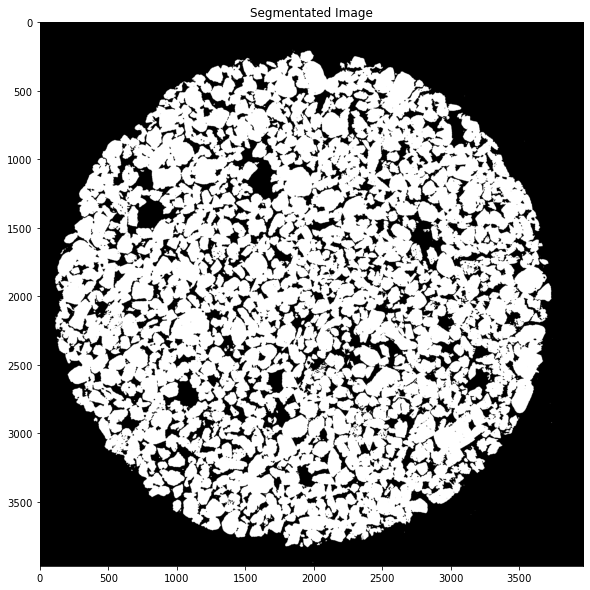

instances of class 1 = (747470,)
instances of class 0 = (252530,)
[0 1] [0 1]
[('High Pass Filter k=9 scale=1', 0.0010524079965242804), ('Variance Filter scale=1', 0.0014885827462661457), ('Gaussian Filter sigma=15 scale=4', 0.004312221527487719), ('Gaussian Filter sigma=15 scale=2', 0.005000373471379509), ('Dilation 2D scale=1', 0.005955249850172438), ('Gaussian Filter sigma=15 scale=1', 0.006364813415783386), ('Base Filter scale=1', 0.006409775962461025), ('Dilation 2D scale=2', 0.007750180984043879), ('Opening 2D scale=1', 0.009550271102766001), ('Dilation 2D scale=4', 0.010389067573393942), ('Erosion 2D scale=1', 0.015341711754333971), ('Erosion 2D scale=4', 0.019614259316435036), ('Closing 2D scale=4', 0.030336999228021428), ('Base Filter scale=4', 0.04653874177391412), ('Median Filter size=5 scale=4', 0.0509726277845419), ('Base Filter scale=2', 0.053882775897223546), ('Closing 2D scale=1', 0.057242204191503804), ('Opening 2D scale=4', 0.06018651667757424), ('Opening 2D scale=2',

  0%|          | 0/23 [00:00<?, ?it/s]

Making train data...
Fitting model...
x_train shape = (1000000, 23), y_train shape = (1000000,)
Making predictions...


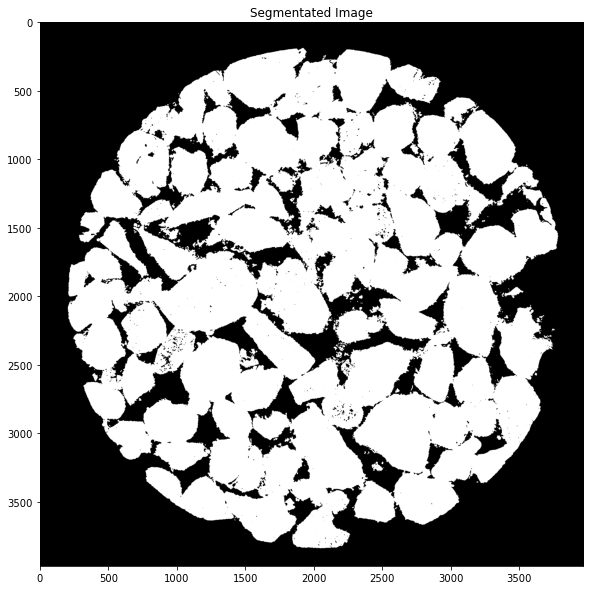

instances of class 1 = (792188,)
instances of class 0 = (207812,)
[0 1] [0 1]
[('High Pass Filter k=9 scale=1', 0.0004836634643964433), ('Variance Filter scale=1', 0.0006034449148970645), ('Base Filter scale=1', 0.002600994650549635), ('Gaussian Filter sigma=15 scale=4', 0.002802882076892552), ('Gaussian Filter sigma=15 scale=2', 0.0033754793281140037), ('Gaussian Filter sigma=15 scale=1', 0.004418745059085696), ('Dilation 2D scale=1', 0.004514098128955851), ('Dilation 2D scale=4', 0.005870641410197217), ('Erosion 2D scale=1', 0.006806721821890089), ('Base Filter scale=2', 0.012826922319227002), ('Opening 2D scale=1', 0.015436363702678946), ('Erosion 2D scale=4', 0.02061429750497856), ('Base Filter scale=4', 0.04313749091453331), ('Dilation 2D scale=2', 0.04825125538809965), ('Closing 2D scale=1', 0.05565410311508176), ('Erosion 2D scale=2', 0.06329012339983964), ('Closing 2D scale=2', 0.06906953305975372), ('Median Filter size=5 scale=4', 0.0721265971075656), ('Opening 2D scale=4', 0.

  0%|          | 0/23 [00:00<?, ?it/s]

Making train data...
Fitting model...
x_train shape = (1000000, 23), y_train shape = (1000000,)
Making predictions...


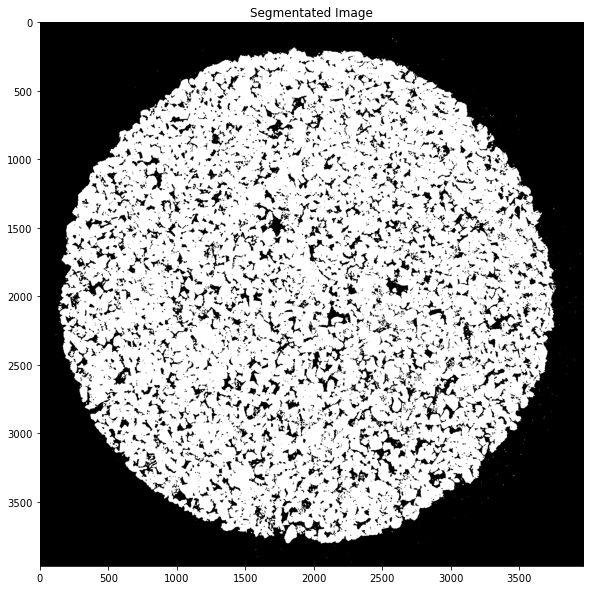

instances of class 1 = (806257,)
instances of class 0 = (193743,)
[0 1] [0 1]
[('High Pass Filter k=9 scale=1', 0.0020067478474879853), ('Variance Filter scale=1', 0.002616502251049995), ('Gaussian Filter sigma=15 scale=4', 0.008481125198245168), ('Gaussian Filter sigma=15 scale=2', 0.009273090830243655), ('Gaussian Filter sigma=15 scale=1', 0.010450402378637083), ('Base Filter scale=4', 0.012089405739050822), ('Dilation 2D scale=4', 0.013174207480157664), ('Base Filter scale=1', 0.013783981192841362), ('Erosion 2D scale=4', 0.022285247845576745), ('Median Filter size=5 scale=4', 0.022901024259425574), ('Closing 2D scale=4', 0.0241454698551453), ('Dilation 2D scale=1', 0.024497729169416033), ('Dilation 2D scale=2', 0.027478831274187786), ('Opening 2D scale=1', 0.0359429906929831), ('Erosion 2D scale=1', 0.04134869978274008), ('Opening 2D scale=4', 0.044680099922531163), ('Base Filter scale=2', 0.04977984411032183), ('Erosion 2D scale=2', 0.053306576211420424), ('Closing 2D scale=1', 0.

  0%|          | 0/23 [00:00<?, ?it/s]

Making train data...
Fitting model...
x_train shape = (1000000, 23), y_train shape = (1000000,)
Making predictions...


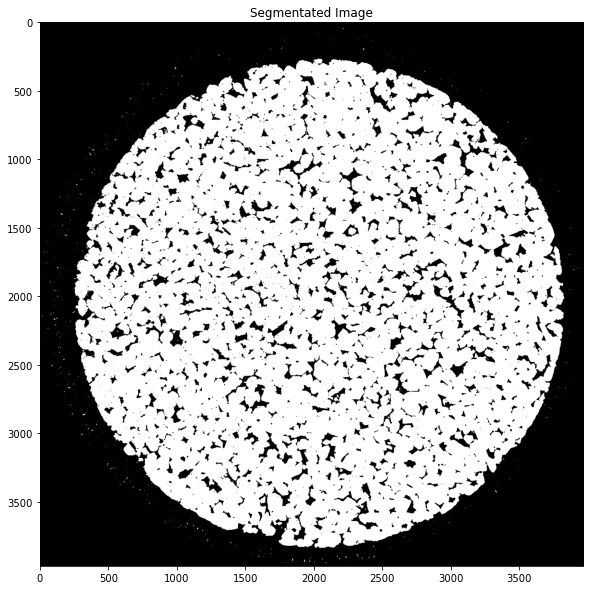

instances of class 1 = (877855,)
instances of class 0 = (122145,)
[0 1] [0 1]
[('High Pass Filter k=9 scale=1', 0.0018839289822281894), ('Variance Filter scale=1', 0.00203506917102139), ('Gaussian Filter sigma=15 scale=4', 0.005595974225870088), ('Base Filter scale=1', 0.006906249615412618), ('Dilation 2D scale=1', 0.009170508506606527), ('Gaussian Filter sigma=15 scale=2', 0.010557737446473718), ('Opening 2D scale=1', 0.011941354669705242), ('Dilation 2D scale=4', 0.013214795318144174), ('Base Filter scale=4', 0.01368133894774124), ('Dilation 2D scale=2', 0.02075797762961597), ('Erosion 2D scale=1', 0.02139890309522963), ('Closing 2D scale=1', 0.02478375028588239), ('Base Filter scale=2', 0.025084325047642905), ('Erosion 2D scale=4', 0.033225131128656334), ('Gaussian Filter sigma=15 scale=1', 0.033780249429879144), ('Closing 2D scale=4', 0.05434464041457794), ('Erosion 2D scale=2', 0.05929310504401927), ('Median Filter size=5 scale=1', 0.06060233327230325), ('Closing 2D scale=2', 0.07

  0%|          | 0/23 [00:00<?, ?it/s]

Making train data...
Fitting model...
x_train shape = (1000000, 23), y_train shape = (1000000,)
Making predictions...


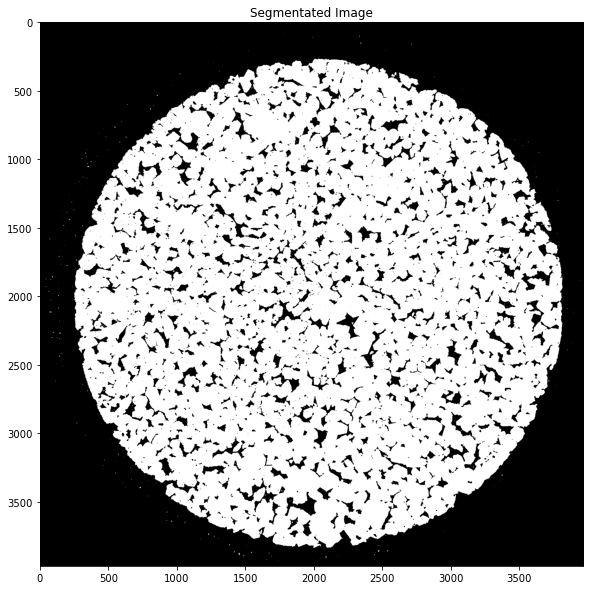

instances of class 1 = (877708,)
instances of class 0 = (122292,)
[0 1] [0 1]
[('High Pass Filter k=9 scale=1', 0.0019754890938300136), ('Variance Filter scale=1', 0.002011777180433666), ('Gaussian Filter sigma=15 scale=4', 0.006118487251458708), ('Dilation 2D scale=1', 0.008234791484861939), ('Base Filter scale=1', 0.008805592731644588), ('Gaussian Filter sigma=15 scale=2', 0.009929403944706289), ('Base Filter scale=2', 0.010284681488084627), ('Opening 2D scale=1', 0.010776308275143162), ('Dilation 2D scale=4', 0.010920585909882981), ('Erosion 2D scale=1', 0.014519518553149301), ('Dilation 2D scale=2', 0.018765696517376723), ('Closing 2D scale=1', 0.03025610586189999), ('Erosion 2D scale=2', 0.030933625738508743), ('Base Filter scale=4', 0.031016409447479867), ('Gaussian Filter sigma=15 scale=1', 0.0325146905633637), ('Opening 2D scale=2', 0.04867686889232214), ('Opening 2D scale=4', 0.05275796432617255), ('Erosion 2D scale=4', 0.059215363078475296), ('Median Filter size=5 scale=1', 0

In [31]:
for i in range(8):
    if i != 6:
        name = image_name
    else:
        name = image_name_6
    
    print(f'image number {i}')
    res, sgm = segmentate_img(i, name)
    metrics = score_result(i, name, res)
    print(sorted(sgm.feature_weights().items(), key = lambda x: x[1]))
    print(metrics)
    print('\n \n')

In [ ]:
scalled_filters =[
                filters_2d.MedianFilter(size=5, scale=4),   filters_2d.GaussianFilter(15, scale=4),  filters_2d.LaplacianDifference(scale=4),
                filters_2d.VarianceFilter(size=3, scale=4), filters_2d.HighPassFilter(k=9, scale=4), filters_2d.BaseFilter2D(scale=4), 
                filters_2d.Erosion(size=3, scale=4), filters_2d.Dilation(size=3, scale=4),
                filters_2d.Closing(size=3, scale=4), filters_2d.Opening(size=3, scale=4)
              ]

In [ ]:
зд